#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

True


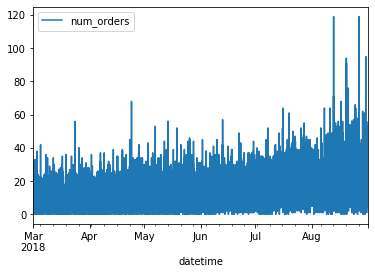

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


num_orders    0
dtype: int64

Пропуски в исходной выборке, всего:  0


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
import time

from IPython.display import display
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

df_taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
df_taxi.sort_index(inplace=True)
print(df_taxi.index.is_monotonic)

df_taxi.plot()
plt.show()

display(df_taxi.head(5))
display(df_taxi.describe())
df_taxi.info()
display(df_taxi.isnull().sum())

# Общий процент пропусков в выборке
gaps = df_taxi.isnull().sum().sum()
print('Пропуски в исходной выборке, всего: ', gaps)

## Анализ

### Выполним его ресемплирование и посчитаем скользащее среднее.

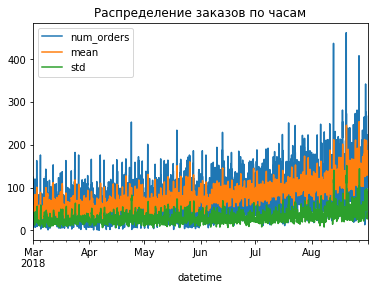

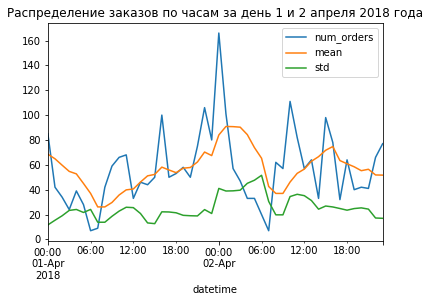

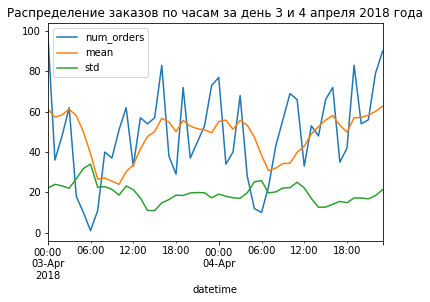

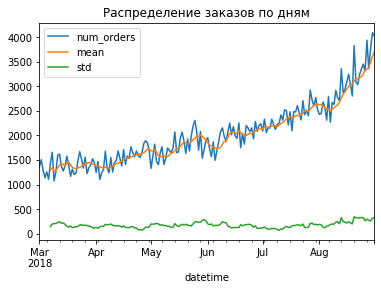

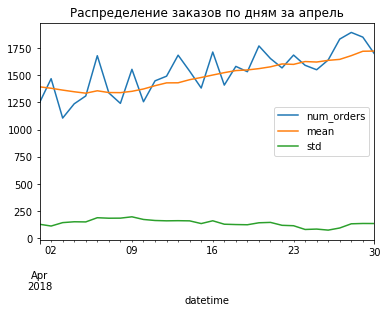

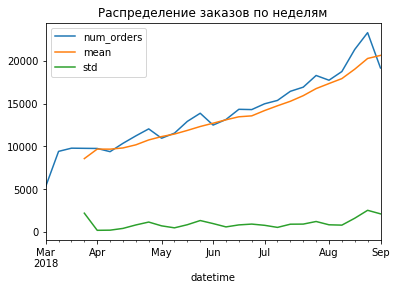

In [3]:
df_hour = df_taxi.resample('1H').sum()
df_hour['mean'] = df_hour['num_orders'].rolling(7).mean()
df_hour['std'] = df_hour['num_orders'].rolling(7).std()

df_hour.plot()
plt.title('Распределение заказов по часам');
plt.show()

df_hour['2018-04-01':'2018-04-02'].plot()
plt.title('Распределение заказов по часам за день 1 и 2 апреля 2018 года');
plt.show()

df_hour['2018-04-03':'2018-04-04'].plot()
plt.title('Распределение заказов по часам за день 3 и 4 апреля 2018 года');
plt.show()

df_day = df_taxi.resample('1D').sum()
df_day['mean'] = df_day['num_orders'].rolling(7).mean()
df_day['std'] = df_day['num_orders'].rolling(7).std()

df_day.plot()
plt.title('Распределение заказов по дням');
plt.show()

df_day['2018-04-01':'2018-04-30'].plot()
plt.title('Распределение заказов по дням за апрель');
plt.show()

df_week = df_taxi.resample('1W').sum()
df_week['mean'] = df_week['num_orders'].rolling(4).mean()
df_week['std'] = df_week['num_orders'].rolling(4).std()

df_week.plot()
plt.title('Распределение заказов по неделям');
plt.show()

<div class="alert alert-block alert-info">
<b>Вывод</b>

1. Временной ряд не является стационарным, так как у него меняется среднее значение.
2. Наблюдаем общий тренд увеличения числа заказов со временем за период с марта по сентябрь.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий</b>
    
Есть три вида нестационарности: тренд, сезонность, непостоянство дисперсии)<br>
Стационарный ряд - это когда ничего из перечисленного в ряде не наблюдается (очистили его). Нужно это для одного из методов прогрнозироваия АРИМА, например. Для метода прогнозирования "регрессия" это понятие можно не использовать.
</div>

### Проведем анализ трендов и сезонности по дням и по часам

#### Аддетивная модель по дням

2018-03-12 00:00:00 - день недели  0
2018-03-19 00:00:00 - день недели  0


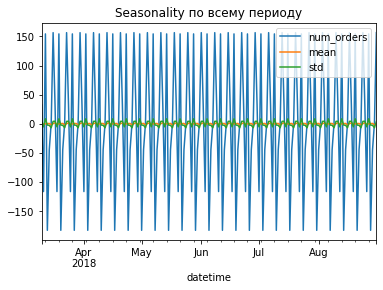

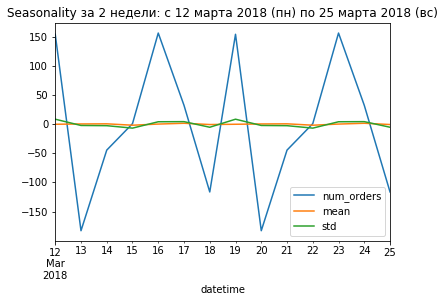

In [4]:
decomposed = seasonal_decompose(df_day['2018-03-10':'2018-09'], model ='additive')
print(df_day.index[11], '- день недели ', df_day.index[11].weekday()) # 0 - понедельник
print(df_day.index[18], '- день недели ', df_day.index[11].weekday())
decomposed.seasonal['2018-03-10':'2018-09'].plot()
plt.title('Seasonality по всему периоду')
plt.show()
decomposed.seasonal['2018-03-12':'2018-03-25'].plot()
plt.title('Seasonality за 2 недели: с 12 марта 2018 (пн) по 25 марта 2018 (вс)')
plt.show()

<div class="alert alert-block alert-info">
<b>Вывод</b>

Видим, что 
1. Закономирности циклично повторяются от недели к неделе и от месяца к месяцу. 
2. Максимальное цисло заказов наблюдаем по понедельникам и пятницам, манимальное - по вторникам и воскресеньям.
</div>

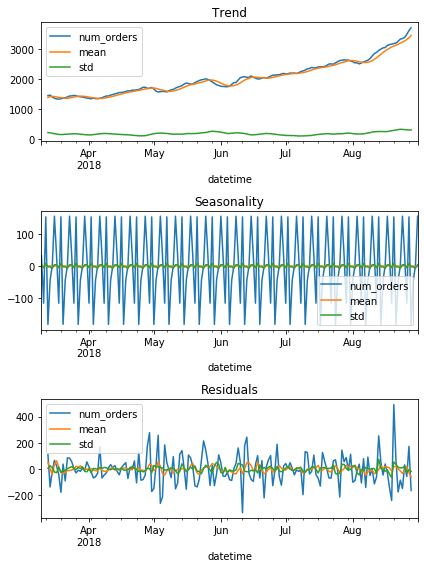

In [5]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

#### Мультипликативная модель по дням

2018-03-12 00:00:00 - день недели  0
2018-03-19 00:00:00 - день недели  0


Text(0.5, 1.0, 'Seasonality за 2 недели: с 12 марта 2018 (пн) по 25 марта 2018 (вс)')

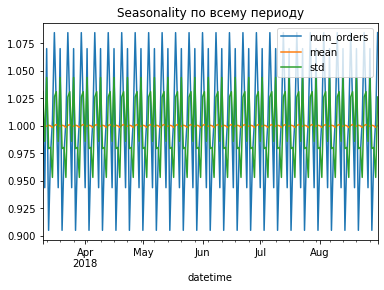

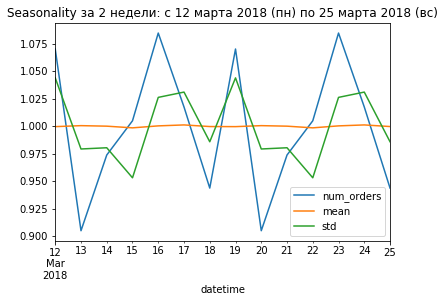

In [6]:
decomposed = seasonal_decompose(df_day['2018-03-10':'2018-09'], model = 'multiplicative')
print(df_day.index[11], '- день недели ', df_day.index[11].weekday())
print(df_day.index[18], '- день недели ', df_day.index[11].weekday())
decomposed.seasonal['2018-03-10':'2018-09'].plot()
plt.title('Seasonality по всему периоду')
decomposed.seasonal['2018-03-12':'2018-03-25'].plot()
plt.title('Seasonality за 2 недели: с 12 марта 2018 (пн) по 25 марта 2018 (вс)')

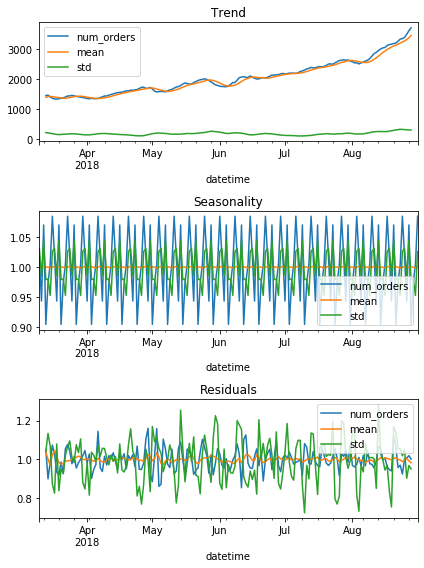

In [7]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div class="alert alert-block alert-info">
<b>Вывод</b>

Видим, что аддетивная и мультипликативная модели приводят к идентичным выводам:

1. Наблюдаем общий тренд увеличения числа заказов со временем.
2. закономирности циклично повторяются от недели к неделе. 
3. Максимальное цисло заказов наблюдаем по понедельникам и пятницам, манимальное - по вторникам и воскресеньям.
</div>

#### Аддетивная модель по часам

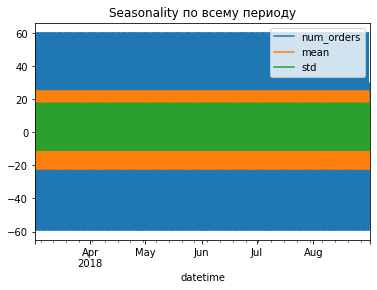

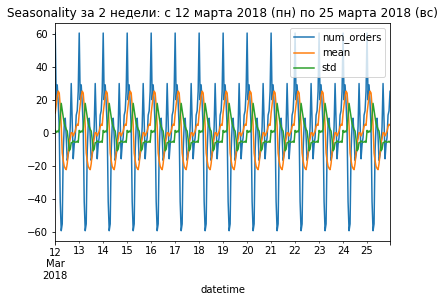

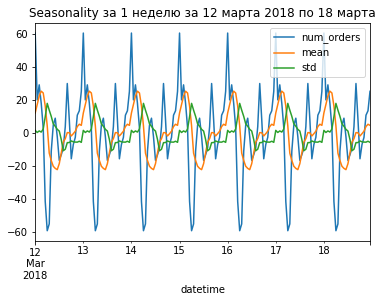

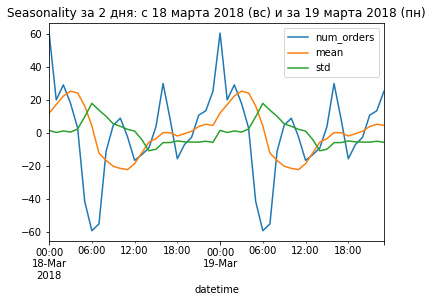

In [8]:
decomposed = seasonal_decompose(df_hour['2018-03-02':'2018-09'], model ='additive')
#print(df_hour.index[11], '- день недели ', df_hour.index[11].weekday())
#print(df_hour.index[18], '- день недели ', df_hour.index[11].weekday())
decomposed.seasonal['2018-03-01':'2018-09'].plot()
plt.title('Seasonality по всему периоду')
decomposed.seasonal['2018-03-12':'2018-03-25'].plot()
plt.title('Seasonality за 2 недели: с 12 марта 2018 (пн) по 25 марта 2018 (вс)')
plt.show()
decomposed.seasonal['2018-03-12':'2018-03-18'].plot()
plt.title('Seasonality за 1 неделю за 12 марта 2018 по 18 марта')
plt.show()
decomposed.seasonal['2018-03-18':'2018-03-19'].plot()
plt.title('Seasonality за 2 дня: c 18 марта 2018 (вс) и за 19 марта 2018 (пн)')
plt.show()

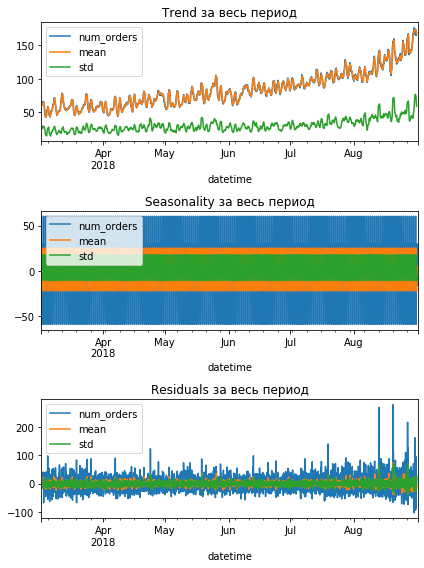

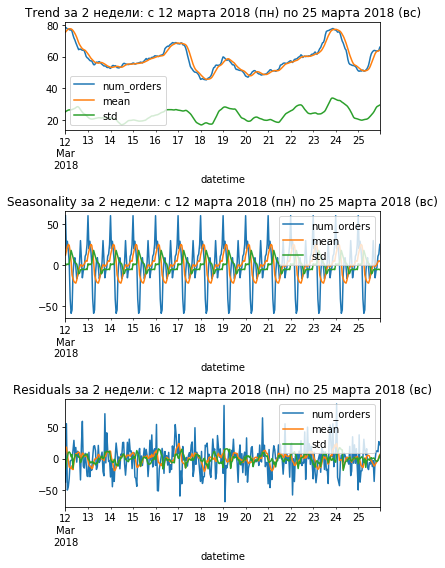

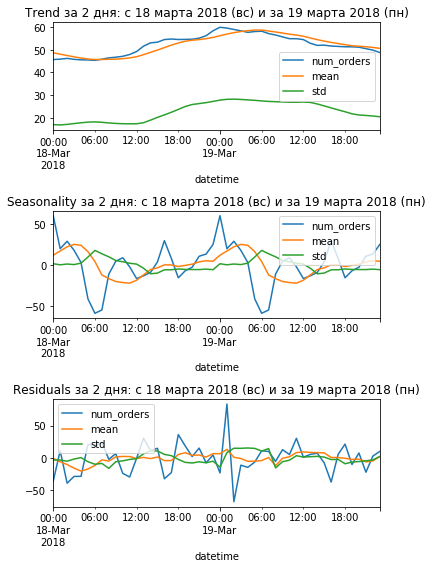

In [9]:
#NEW_20.01.2022
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend за весь период')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality за весь период')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals за весь период')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend['2018-03-12':'2018-03-25'].plot(ax=plt.gca())
plt.title('Trend за 2 недели: с 12 марта 2018 (пн) по 25 марта 2018 (вс)')
plt.subplot(312)
decomposed.seasonal['2018-03-12':'2018-03-25'].plot(ax=plt.gca())
plt.title('Seasonality за 2 недели: с 12 марта 2018 (пн) по 25 марта 2018 (вс)')
plt.subplot(313)
decomposed.resid['2018-03-12':'2018-03-25'].plot(ax=plt.gca())
plt.title('Residuals за 2 недели: с 12 марта 2018 (пн) по 25 марта 2018 (вс)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-03-18':'2018-03-19'].plot(ax=plt.gca())
plt.title('Trend за 2 дня: c 18 марта 2018 (вс) и за 19 марта 2018 (пн)')
plt.subplot(312)
decomposed.seasonal['2018-03-18':'2018-03-19'].plot(ax=plt.gca())
plt.title('Seasonality за 2 дня: c 18 марта 2018 (вс) и за 19 марта 2018 (пн)')
plt.subplot(313)
decomposed.resid['2018-03-18':'2018-03-19'].plot(ax=plt.gca())
plt.title('Residuals за 2 дня: c 18 марта 2018 (вс) и за 19 марта 2018 (пн)')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>Вывод</b>

1. Наблюдаем общий тренд увеличения числа заказов со временем.
2. закономирности циклично повторяются от недели к неделе, от дня ко дню. 
3. Дневная сезонность: максимальное цисло заказов наблюдаем по понедельникам и пятницам, манимальное - по вторникам и воскресеньям.
4. Внутрисуточная сезонность: наблюдаем резкое cнижение числа заказов после 6 утра и резкое увеличение числа заказов в полночь.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий</b>
    
Инструмент декомпозиции в частности, а графический анализ временных рядов как в принципе - важный этап моделирования рядов. Позволяет увидеть продажи визуально, а это помогает сделать предвариетльные выводы
    
В реальности бизнеса есть все три вида сезонности:
1) дневная сезонность -  данные собраны по дням, т.е. будни и выходные имеют разные продажи
2) внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером
3) месячная сезонность: когда продажи лета и осени - разные.

Если строить прогноз на длительный период времени, то без учёта всех видов сезонности не обойтись.
Например, если в данных восходящий тренд, то возникает: 
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)

    
Совет:
    
на горизонте прогнозирования несколько часов или дней предположить что у нас тренд.

### Исследуем разности временного ряда (для ресемплирования 1 день и для ресемлирования 1 час)

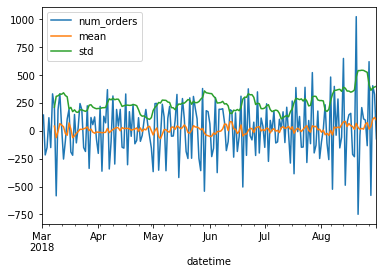

In [10]:
df_day_sub = df_day - df_day.shift()
df_day_sub['mean'] = df_day_sub['num_orders'].rolling(7).mean()
df_day_sub['std'] = df_day_sub['num_orders'].rolling(7).std()
df_day_sub.plot()
plt.show()

<div class="alert alert-block alert-info">
<b>Вывод</b>

После преобразования временной ряд стал более стационарным.

</div>

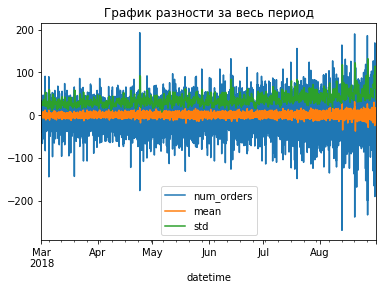

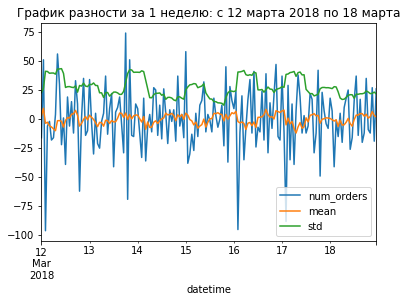

In [11]:
df_hour_sub = df_hour - df_hour.shift()
df_hour_sub['mean'] = df_hour_sub['num_orders'].rolling(10).mean()
df_hour_sub['std'] = df_hour_sub['num_orders'].rolling(10).std()

df_hour_sub['2018-03-01':'2018-09'].plot()
plt.title('График разности за весь период')
plt.show()

df_hour_sub['2018-03-12':'2018-03-18'].plot()
plt.title('График разности за 1 неделю: c 12 марта 2018 по 18 марта')
plt.show()

<div class="alert alert-block alert-info">
<b>Вывод</b>

После преобразования временной ряд стал более стационарным.
</div>

## Обучение

### По дням

### Создадим признаки для модели

In [12]:
def make_features(data, max_lag, rolling_mean_size):
#    data['year'] = data.index.year - исключено 20.01.2022
#    data['month'] = data.index.month - исключено 20.01.2022
#    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df_day, 2, 7)
print(df_day.head())

            num_orders  mean  std  dayofweek   lag_1   lag_2  rolling_mean
datetime                                                                  
2018-03-01        1364   NaN  NaN          3     NaN     NaN           NaN
2018-03-02        1506   NaN  NaN          4  1364.0     NaN           NaN
2018-03-03        1290   NaN  NaN          5  1506.0  1364.0           NaN
2018-03-04        1141   NaN  NaN          6  1290.0  1506.0           NaN
2018-03-05        1259   NaN  NaN          0  1141.0  1290.0           NaN


<div class="alert alert-block alert-info">
<b>Комментарий</b>

1) Фактор год: НЕТ, не подходит. У нас данных меньше года. Поэтому будет просто константа.<br>
2) Фактор месяц: НЕТ, у нас в истории всего один март, май.... Да и горизоно прогноза - часы. Поэтому сезонность времени года в тренде уже заложена.<br>
3) Фактор день: НЕТ, также не подходит, будет просто последовательность чисел. Возможно отдельно сделать маркировку начала или конца месяца (например, 1-3 числа месяца заполнить единицами, оставшиеся дни - нулями.<br>
4) Фактор день недели: ДА, т.к. у нас есть недельная сезонность<br>
5) Фактор час: ДА, т.к. есть часовая (суточная) сезонность.
6) Факто lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.
7) Фактор rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда 
    
Факторы mean и std можно не испоьзовать. 
    Первый (mean) почти совпадает со скользящим средним. 
    Второй - очень сложный для использования потом. Ведь нам модель надо будет использовать для прогнозирования. Т.е. надо будет сначала построить прогноз std на час вперёд, а потом уже сам прогноз продаж. А std скорее всего будет случайной величиной, а значит предскать будет невозможно.

</div>

<div class="alert alert-block alert-info">
<b>Рекоммендация</b>
    
Учитывать горизонт прогноза: если задача стоит среднесрочного и долгосрочного прогноза, то месяц нам в помощь (при этом данных должно быть не меннее 2-х / 3-х лет). Если задача краткосрочного прогнозирования, то месяц не использовать, он уже в тренде заложен.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий</b>
    
Lag: его называют ещё параметром авторегрессии. 
Допустим lag=1, он учитывает (для удобства будем считать, что продажи собраны по дням) как вчерашние продажи (вчерашние события) поалияли на сегоняшние. Lag=2: учитывает как позавчерашние продажи влияютна сегодняшние и т.д.
    
Скользящее среднее:
Предположим rolling=10 - скользящее среднее. Мы ищем среднее по 10 точкам, потом по следующим 10 точек, и т.д. - это некое подобие тренда будет - средней линии, т.е. сглаживание колебаний/выбросов. 
Его легко увидеть на пределе: допустим длина ряда 100 дней, тогда rolling(100) - это просто одно число, среднее всего ряда. 
    
Если выставить сезонности - hour и день, то дополнительные факторы могут быть такие: лаг =1 (максимум 2), а скользящее среднее = 24 (среднее за сутки). Начинаем с этих переменных, тогда модель будет приемлемая по точности и без большого числа ненужных факторов, а это значит и для бизнес-подразделений она будет понятнее.

</div>

<div class="alert alert-block alert-info">
<b>Комментарий к коду</b>

Число переменных (lag, rolling_mean_size) при вызове фукнции выставлены в соотвествии с комментарием выше:

1. lag = 2
2. rolling_mean_size = 7 для модели по дням, rolling_mean_size = 24 для модели по часам
</div>

#### Разобьем датасет на обучающую и тестовую выборки

In [13]:
train, test = train_test_split(df_day, shuffle=False, test_size=0.2)
train = train.dropna()
print('Обучающая выборка содержит данные за период с ',train.index.min().strftime('%d %b %Y')\
      , 'по', train.index.max().strftime('%d %B %Y'))
print(train.iloc[9:12])
print()
print('Тестовая выборка содержит данные за период с ',test.index.min().strftime('%d %b %Y')\
      , 'по', test.index.max().strftime('%d %B %Y'))
print(test.head(3)) 

print('Размеры обучающей и тестовой выборок: ')
print('Train: ', train.shape)
print('Test: ', test.shape) 

Обучающая выборка содержит данные за период с  08 Mar 2018 по 25 July 2018
            num_orders         mean         std  dayofweek   lag_1   lag_2  \
datetime                                                                     
2018-03-17        1387  1459.571429  136.651451          5  1577.0  1384.0   
2018-03-18        1168  1397.857143  158.469165          6  1387.0  1577.0   
2018-03-19        1315  1354.000000  125.057320          0  1168.0  1387.0   

            rolling_mean  
datetime                  
2018-03-17   1442.428571  
2018-03-18   1459.571429  
2018-03-19   1397.857143  

Тестовая выборка содержит данные за период с  26 Jul 2018 по 31 August 2018
            num_orders         mean         std  dayofweek   lag_1   lag_2  \
datetime                                                                     
2018-07-26        2400  2489.285714  132.423203          3  2515.0  2422.0   
2018-07-27        2923  2534.428571  210.238640          4  2400.0  2515.0   
2018-07-28

#### Выделим целевой признак и признаки для обучения

In [14]:
features_train = train.drop(['num_orders','mean','std'], axis = 1) #Изменено 20.01.2022
target_train = train['num_orders']
features_test = test.drop(['num_orders','mean','std'], axis=1) #Изменено 20.01.2022
target_test = test['num_orders']

In [15]:
train

,num_orders,mean,std,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-08,1659,1343.571429,200.603969,3,1441.0,1109.0,1301.428571
2018-03-09,1076,1282.142857,208.266199,4,1659.0,1441.0,1343.571429
2018-03-10,1267,1278.857143,208.303007,5,1076.0,1659.0,1282.142857
2018-03-11,1600,1344.428571,228.900165,6,1267.0,1076.0,1278.857143
2018-03-12,1622,1396.285714,246.743939,0,1600.0,1267.0,1344.428571
...,...,...,...,...,...,...,...
2018-07-21,2460,2402.857143,179.650984,5,2607.0,2478.0,2408.857143
2018-07-22,2315,2417.428571,165.244120,6,2460.0,2607.0,2402.857143
2018-07-23,2706,2449.571429,198.256448,0,2315.0,2460.0,2417.428571


In [16]:
features_train

,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,
2018-03-08,3,1441.0,1109.0,1301.428571
2018-03-09,4,1659.0,1441.0,1343.571429
2018-03-10,5,1076.0,1659.0,1282.142857
2018-03-11,6,1267.0,1076.0,1278.857143
2018-03-12,0,1600.0,1267.0,1344.428571
...,...,...,...,...
2018-07-21,5,2607.0,2478.0,2408.857143
2018-07-22,6,2460.0,2607.0,2402.857143
2018-07-23,0,2315.0,2460.0,2417.428571


In [17]:
test.head(5)

,num_orders,mean,std,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-07-26,2400,2489.285714,132.423203,3,2515.0,2422.0,2500.428571
2018-07-27,2923,2534.428571,210.238640,4,2400.0,2515.0,2489.285714
2018-07-28,2725,2572.285714,218.306905,5,2923.0,2400.0,2534.428571
2018-07-29,2596,2612.428571,186.651955,6,2725.0,2923.0,2572.285714
2018-07-30,2774,2622.142857,193.959986,0,2596.0,2725.0,2612.428571


In [18]:
features_test.head(5)

,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,
2018-07-26,3,2515.0,2422.0,2500.428571
2018-07-27,4,2400.0,2515.0,2489.285714
2018-07-28,5,2923.0,2400.0,2534.428571
2018-07-29,6,2725.0,2923.0,2572.285714
2018-07-30,0,2596.0,2725.0,2612.428571


#### Обучим модель линейной регрессии

In [19]:
model = LinearRegression() 
model.fit(features_train, target_train)
prediction_train = model.predict(features_train)
prediction_test = model.predict(features_test)

#### Расчитаем MAE и RMSE стационарного ряда

In [20]:
MAE_train = mean_absolute_error(train['num_orders'], prediction_train)
MAE_test = mean_absolute_error(test['num_orders'], prediction_test)
print("MAE обучающей выборки:", MAE_train)
print("MAE тестовой выборки: ", MAE_test)

#расчет RMSE
def rmse(validation, predictions):
    return mean_squared_error(validation, predictions) ** 0.5

rmse_train = rmse(train['num_orders'], prediction_train)
rmse_test = rmse(test['num_orders'], prediction_test)
print("RMSE обучающей выборки:", rmse_train)
print("RMSE тестовой выборки: ", rmse_test)

MAE обучающей выборки: 141.4289315387003
MAE тестовой выборки:  211.6215911066854
RMSE обучающей выборки: 174.6159761253356
RMSE тестовой выборки:  280.6845766474444


<div class="alert alert-block alert-info">
<b>Вывод</b>

Получили MAE = 210 и RMSE = 278. Ниже пробуем модель для часа.
</div>

### По часам

#### Создадим признаки для модели

In [21]:
df_hour['hour'] = df_hour.index.hour #дополнительный признак по часам #Изменено 20.01.2022
make_features(df_hour, 2, 24) #Изменено 20.01.2022
print(df_hour.head())

                     num_orders  mean  std  hour  dayofweek  lag_1  lag_2  \
datetime                                                                    
2018-03-01 00:00:00         124   NaN  NaN     0          3    NaN    NaN   
2018-03-01 01:00:00          85   NaN  NaN     1          3  124.0    NaN   
2018-03-01 02:00:00          71   NaN  NaN     2          3   85.0  124.0   
2018-03-01 03:00:00          66   NaN  NaN     3          3   71.0   85.0   
2018-03-01 04:00:00          43   NaN  NaN     4          3   66.0   71.0   

                     rolling_mean  
datetime                           
2018-03-01 00:00:00           NaN  
2018-03-01 01:00:00           NaN  
2018-03-01 02:00:00           NaN  
2018-03-01 03:00:00           NaN  
2018-03-01 04:00:00           NaN  


#### Разобьем датасет на обучающую и тестовую выборки

In [22]:
train, test = train_test_split(df_hour, shuffle=False, test_size=0.2)
train = train.dropna()
print('Обучающая выборка содержит данные за период с ',train.index.min().strftime('%d %b %Y %H')\
      , 'по', train.index.max().strftime('%d %B %Y %H'))
print(train.iloc[9:12])
print()
print('Тестовая выборка содержит данные за период с ',test.index.min().strftime('%d %b %Y %H')\
      , 'по', test.index.max().strftime('%d %B %Y %H'))
print(test.head(3)) 

print('Размеры обучающей и тестовой выборок: ')
print('Train: ', train.shape)
print('Test: ', test.shape) 

Обучающая выборка содержит данные за период с  02 Mar 2018 00 по 26 July 2018 03
                     num_orders       mean        std  hour  dayofweek  lag_1  \
datetime                                                                        
2018-03-02 09:00:00          45  29.142857  22.296701     9          4   46.0   
2018-03-02 10:00:00          54  27.714286  19.880596    10          4   45.0   
2018-03-02 11:00:00          91  37.857143  30.541931    11          4   54.0   

                     lag_2  rolling_mean  
datetime                                  
2018-03-02 09:00:00    7.0     56.333333  
2018-03-02 10:00:00   46.0     55.333333  
2018-03-02 11:00:00   45.0     54.916667  

Тестовая выборка содержит данные за период с  26 Jul 2018 04 по 31 August 2018 23
                     num_orders        mean        std  hour  dayofweek  \
datetime                                                                  
2018-07-26 04:00:00         131  130.428571  41.632748     4     

#### Выделим целевой признак и признаки для обучения

In [23]:
features_train = train.drop(['num_orders','mean','std'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders','mean','std'], axis=1)
target_test = test['num_orders']

In [24]:
train

,num_orders,mean,std,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,,,
2018-03-02 00:00:00,90,72.285714,22.684167,0,4,58.0,113.0,56.833333
2018-03-02 01:00:00,120,79.000000,29.005747,1,4,90.0,58.0,55.416667
2018-03-02 02:00:00,75,83.285714,25.097904,2,4,120.0,90.0,56.875000
2018-03-02 03:00:00,64,83.714286,24.675996,3,4,75.0,120.0,57.041667
2018-03-02 04:00:00,20,77.142857,34.391998,4,4,64.0,75.0,56.958333
...,...,...,...,...,...,...,...,...
2018-07-25 23:00:00,138,109.857143,26.060369,23,2,84.0,110.0,103.625000
2018-07-26 00:00:00,149,113.857143,29.918938,0,3,138.0,84.0,104.791667
2018-07-26 01:00:00,73,114.571429,28.675525,1,3,149.0,138.0,104.291667


In [25]:
features_train.head(5)

,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,
2018-03-02 00:00:00,0,4,58.0,113.0,56.833333
2018-03-02 01:00:00,1,4,90.0,58.0,55.416667
2018-03-02 02:00:00,2,4,120.0,90.0,56.875000
2018-03-02 03:00:00,3,4,75.0,120.0,57.041667
2018-03-02 04:00:00,4,4,64.0,75.0,56.958333


In [26]:
test

,num_orders,mean,std,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,,,
2018-07-26 04:00:00,131,130.428571,41.632748,4,3,141.0,197.0,106.375000
2018-07-26 05:00:00,83,130.285714,41.819909,5,3,131.0,141.0,106.666667
2018-07-26 06:00:00,21,113.571429,58.340544,6,3,83.0,131.0,107.250000
2018-07-26 07:00:00,39,97.857143,61.912380,7,3,21.0,83.0,105.416667
2018-07-26 08:00:00,80,98.857143,61.499129,8,3,39.0,21.0,104.541667
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,167.428571,40.244491,19,4,207.0,217.0,164.875000
2018-08-31 20:00:00,154,165.714286,40.569752,20,4,136.0,207.0,167.541667
2018-08-31 21:00:00,159,169.428571,38.196235,21,4,154.0,136.0,168.041667


In [27]:
features_test.head(5)

,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,
2018-07-26 04:00:00,4,3,141.0,197.0,106.375000
2018-07-26 05:00:00,5,3,131.0,141.0,106.666667
2018-07-26 06:00:00,6,3,83.0,131.0,107.250000
2018-07-26 07:00:00,7,3,21.0,83.0,105.416667
2018-07-26 08:00:00,8,3,39.0,21.0,104.541667


#### Обучим модель линейной регрессии

In [28]:
model = LinearRegression() 
model.fit(features_train, target_train)
prediction_train = model.predict(features_train)
prediction_test = model.predict(features_test)

#### Расчитаем MAE и RMSE

In [29]:
MAE_train = mean_absolute_error(train['num_orders'], prediction_train)
MAE_test = mean_absolute_error(test['num_orders'], prediction_test)
print("MAE обучающей выборки:", MAE_train)
print("MAE тестовой выборки: ", MAE_test)

#расчет RMSE
def rmse(validation, predictions):
    return mean_squared_error(validation, predictions) ** 0.5

rmse_train = rmse(train['num_orders'], prediction_train)
rmse_test = rmse(test['num_orders'], prediction_test)
print("RMSE обучающей выборки:", rmse_train)
print("RMSE тестовой выборки: ", rmse_test)

MAE обучающей выборки: 22.776263666099975
MAE тестовой выборки:  35.094213921801895
RMSE обучающей выборки: 29.33311504642901
RMSE тестовой выборки:  46.682946488708296


<div class="alert alert-block alert-info">
<b>Вывод</b>

Получили MAE = 29,3 и RMSE = 46,7. Модель предсказыват будущие заказы по часам с RMSE < 48.

Нам удалось найти модель c RMSE < 48.
</div>

#### Визуализация модели линейной регрессии

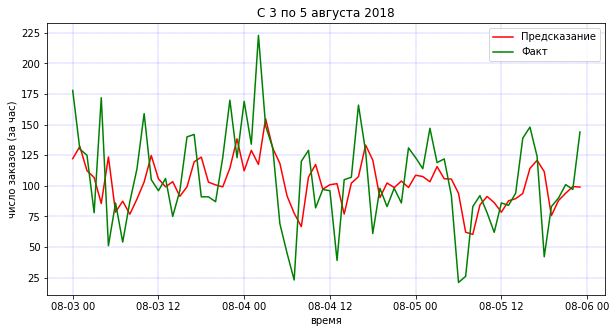

In [30]:
## train['num_orders'], prediction_train
pred_test = pd.Series(prediction_test)
pred_test = pred_test.to_frame(name = 'num_orders')
pred_test = pred_test.set_index(target_test.index)

#pred_test['2018-08-03':'2018-08-05'].plot(figsize=(15,6), label = 'Предсказание')
#target_test['2018-08-03':'2018-08-05']['num_orders'].plot(figsize=(15,6), label = 'Факт')
#plt.show()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pred_test['2018-08-03':'2018-08-05'], color = 'r', label = 'Предсказание')
ax.plot(target_test['2018-08-03':'2018-08-05'], color = 'g', label = 'Факт');
plt.title('C 3 по 5 августа 2018') 
plt.legend()
ax.grid(color = 'blue'\
        ,linewidth = 0.2\
        ,linestyle = '--')
ax.set_xlabel('время')
ax.set_ylabel('число заказов (за час)')
plt.show()

<div class="alert alert-block alert-warning">
<b>Комментарий:</b>
    
У предсказанной модели меньше разброс значений.
Глядя на график, а также добавляя отдельный анализ остатков, можно дорабатывать и улучшать модель дальше.
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48

<div class="alert alert-block alert-info">
<b>Комментарий</b>

Леса, бустинги, регрессии.... могут подобрать хорошие модели на старых данных. Но иногда, как прогноз эти, модели могут оказаться пустышками - не интересными бизнесу. <br> 
1) Модели нужно подсказать причины, по которым происходит колебания продаж (временного ряда): понимать причины колебаний треда, понимать аномалии, учитывать акционные продажи, видеть действия конкурентов , закладывать их в модель и т.д. 

2) Важны три группы факторов: 
1)внешние факторы (например выручка такси-компании зависит от количества машин на линии),
2)есть факторы внутри самих данных (Вы использовали как раз поняти лаг, сезонности), 
3)есть параметры самих моделей (то, что обычно используется при моделировании леса или деревьев).

3)  важно иметь ввиду горизонт прогноза: на кокой период строить прогноз нужно  - на час вперёд, на неделю, на месяц.<br> Это накладывает ограничения на подбор моделей
Удобно составить матрицу  в разрезе:
а)есть тренд/нет тренда; 
б)еть сезоннотсь/нет сезонности;
в)какой горизонт прогноза требуется;
г) есть ли у нас дополнительные факторы для модей

На пересечении знаний о моделях легко будет подобрать адкватную модель.
Не все задачи прогнозирования временных рядов можно хорошо решить лесом и регрессией на основе знаний только факторов ряда. Они хорошо подойдут для коротких горизонтов прогнозирования, а если горизонт чуть больше: недели, месяцы, то тут надо подключать понимание фаткоров продаж самого бизнеса.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий</b>

Поэтой теме можно посмотреть практические материалы здесь:
https://ibf.org/knowledge - заморский институт бизнес-прогнозирования.


Есть классический труд (он НЕ ML, а исключительно на эксель). Но для понимания сути временных рядов - то, что надо:
    УИЧЕРН "Бизнес-прогнозирование"

Идеологически по системе прогнозирования, интересно почитать
ТОМАС УОЛЛАС, Р. СТАЛЬ "планирование продаж и операций" SO&P   
</div>